<a href="https://colab.research.google.com/github/yash-clear/computer-vision/blob/main/ImageCaptioningWithAttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
import matplotlib.pyplot as plt
from keras.backend import set_session
import keras
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter 
warnings.filterwarnings("ignore")

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import json
from glob import glob
from PIL import Image
import pickle



In [ ]:
## The location of the Flickr8K_ photos
dir_Flickr_jpg = '/content/gdrive/MyDrive/datasets/Flicker8k_Dataset'
## The location of the caption file
dir_Flickr_text = '/content/gdrive/MyDrive/datasets/Flickr8k_text/Flickr8k.token.txt'

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 16182


In [ ]:
## read in the Flickr caption data
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])


uni_filenames = np.unique(data.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(data.filename.values).values())

The number of unique file names : 8092
The distribution of the number of captions for each image:


Counter({5: 8092})

In [ ]:

data.head(5)


,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,1,a girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,2,a little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,3,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,4,a little girl in a pink dress going into a woo...


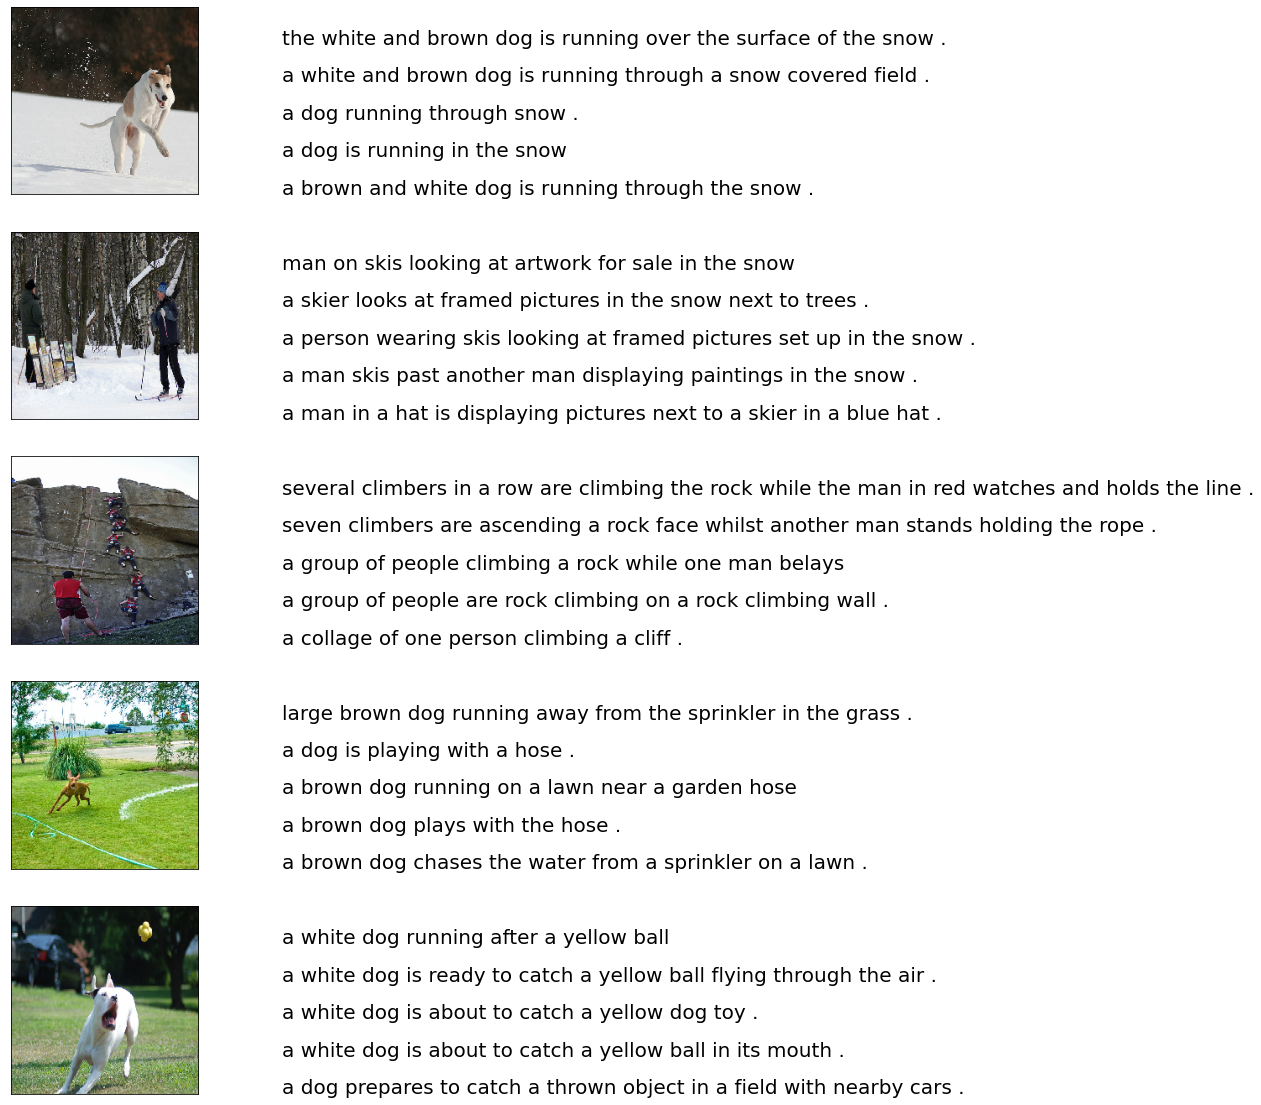

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array

npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:15]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()


In [ ]:
import re
for i in data["filename"]:
    x = re.search("([^\s]+(\.(?i)(jpg|png|gif|bmp))$)", i)
    if (x):
        pass
    else:
        print(f"YES! We have a match!: {i}")


YES! We have a match!: 2258277193_586949ec62.jpg.1
YES! We have a match!: 2258277193_586949ec62.jpg.1
YES! We have a match!: 2258277193_586949ec62.jpg.1
YES! We have a match!: 2258277193_586949ec62.jpg.1
YES! We have a match!: 2258277193_586949ec62.jpg.1


In [ ]:

data.shape

(40460, 3)

In [ ]:

data.loc[data['filename'] == "2258277193_586949ec62.jpg.1"]


,filename,index,caption
6730,2258277193_586949ec62.jpg.1,0,people waiting for the subway
6731,2258277193_586949ec62.jpg.1,1,some people looking out windows in a large bui...
6732,2258277193_586949ec62.jpg.1,2,three people are waiting on a train platform .
6733,2258277193_586949ec62.jpg.1,3,three people standing at a station .
6734,2258277193_586949ec62.jpg.1,4,two woman and one man standing near train trac...


In [ ]:

data = data[data.filename != '2258277193_586949ec62.jpg.1']

In [ ]:
data.shape

(40455, 3)

In [ ]:

def df_word(data):
    vocabulary = []
    for txt in data.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    appen_1 = []
    appen_2 = []
    for i in ct.keys():
        appen_1.append(i)
    for j in ct.values():
        appen_2.append(j)
    data = {"word":appen_1 , "count":appen_2}
    dfword = pd.DataFrame(data)
    dfword = dfword.sort_values(by='count', ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(data)


Vocabulary Size: 8918


In [ ]:

dfword.head(10)

,word,count
0,a,62986
1,.,36577
2,in,18974
3,the,18418
4,on,10743
5,is,9345
6,and,8851
7,dog,8136
8,with,7765
9,man,7265


In [ ]:

data.caption.values

array(['a child in a pink dress is climbing up a set of stairs in an entry way .',
       'a girl going into a wooden building .',
       'a little girl climbing into a wooden playhouse .', ...,
       'a person in a red shirt climbing up a rock face covered in assist handles .',
       'a rock climber in a red shirt .',
       'a rock climber practices on a rock climbing wall .'], dtype=object)

In [ ]:
vocabulary = []
for txt in data.caption.values:
    vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))
ct = Counter(vocabulary)

Vocabulary Size: 8918


In [ ]:

# topn = 50

# def plthist(dfsub, title="The top 50 most frequently appearing words"):
#     plt.figure(figsize=(30,3))
#     plt.bar(dfsub.index,dfsub["count"])
#     plt.yticks(fontsize=20)
#     plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
#     plt.title(title,fontsize=20)
#     plt.show()

# plthist(dfword.iloc[:topn,:],
#         title="The top 50 most frequently appearing words")
# plthist(dfword.iloc[-topn:,:],
#         title="The least 50 most frequently appearing words")

In [ ]:
#make a list of images and caption
img = data["filename"].tolist()
caption = data["caption"].tolist()

In [ ]:

print(f"len(img) : {len(img)}")
print(f"len(caption) : {len(caption)}")

len(img) : 40455
len(caption) : 40455


In [ ]:
#Distinct images an Captions
print(f"Total Unique imgs : {len(set(img))}")
print(f"total unique captions : {len(set(caption))}")

Total Unique imgs : 8091
total unique captions : 40170


In [ ]:
PATH = '/content/gdrive/MyDrive/datasets/Flicker8k_Dataset'
all_captions = []

for caption  in data["caption"].astype(str):
    caption = ' ' + caption+ ' '
    all_captions.append(caption)
all_captions[:5]

[' a child in a pink dress is climbing up a set of stairs in an entry way . ',
 ' a girl going into a wooden building . ',
 ' a little girl climbing into a wooden playhouse . ',
 ' a little girl climbing the stairs to her playhouse . ',
 ' a little girl in a pink dress going into a wooden cabin . ']

In [ ]:
all_img_name_vector = []

for annot in data["filename"]:
    full_image_path = PATH +'/'+ annot

    all_img_name_vector.append(full_image_path)
# all_img_name_vector[:10]

In [ ]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")


len(all_img_name_vector) : 40455
len(all_captions) : 40455


In [ ]:
# Shuffle captions and image_names together
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)


In [ ]:

num_examples = 40000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]
print(f"previously we had {len(all_captions)} captions, and Now we have {len(train_captions)}.")

previously we had 40455 captions, and Now we have 40000.


In [ ]:

from keras.applications.vgg16 import VGG16, preprocess_input

In [ ]:

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    return img, image_path



In [ ]:

image_model = tf.keras.applications.VGG16(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:

image_features_extract_model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [ ]:

encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

print(f"Let's check the BatchDataset shapes--> {image_dataset}")


Let's check the BatchDataset shapes--> <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>


In [ ]:

from tqdm import tqdm

In [ ]:
%%time
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())


100%|██████████| 127/127 [02:10<00:00,  1.03s/it]

CPU times: user 1min 30s, sys: 5.31 s, total: 1min 35s
Wall time: 2min 10s


In [ ]:

print(batch_features.numpy().shape)


(27, 49, 512)


In [ ]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)


In [ ]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)


tokenizer.word_index[''] = 0
tokenizer.index_word[0] = ''


# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')


print(cap_vector.shape)


(40000, 37)


In [ ]:

# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)


# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)


In [ ]:

BATCH_SIZE = 64
BUFFER_SIZE = 50
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 512
attention_features_shape = 49

In [ ]:

# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap


dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x


In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


In [ ]:

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:

checkpoint_path_ckpt = "./checkpoint_final/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

In [ ]:

start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [ ]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['']] * BATCH_SIZE, 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:

EPOCHS = 40

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 10 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 3 Batch 0 Loss 2.0957
Epoch 3 Batch 100 Loss 1.3467
Epoch 3 Batch 200 Loss 1.1478
Epoch 3 Batch 300 Loss 1.0796
Epoch 3 Batch 400 Loss 1.0312
Epoch 3 Loss 1.228326
Time taken for 1 epoch 117.68698596954346 sec

Epoch 4 Batch 0 Loss 0.9758
Epoch 4 Batch 100 Loss 1.0160
Epoch 4 Batch 200 Loss 0.9023
Epoch 4 Batch 300 Loss 0.9328
Epoch 4 Batch 400 Loss 0.8708
Epoch 4 Loss 0.952545
Time taken for 1 epoch 70.5955274105072 sec

Epoch 5 Batch 0 Loss 0.8170
Epoch 5 Batch 100 Loss 0.9085
Epoch 5 Batch 200 Loss 0.8411
Epoch 5 Batch 300 Loss 0.8586
Epoch 5 Batch 400 Loss 0.7826
Epoch 5 Loss 0.850877
Time taken for 1 epoch 71.08449697494507 sec

Epoch 6 Batch 0 Loss 0.7717
Epoch 6 Batch 100 Loss 0.8327
Epoch 6 Batch 200 Loss 0.7358
Epoch 6 Batch 300 Loss 0.8140
Epoch 6 Batch 400 Loss 0.6874
Epoch 6 Loss 0.778158
Time taken for 1 epoch 69.73177599906921 sec

Epoch 7 Batch 0 Loss 0.7012
Epoch 7 Batch 100 Loss 0.7469
Epoch 7 Batch 200 Loss 0.6847
Epoch 7 Batch 300 Loss 0.6894
Epoch 7 Batch 400 

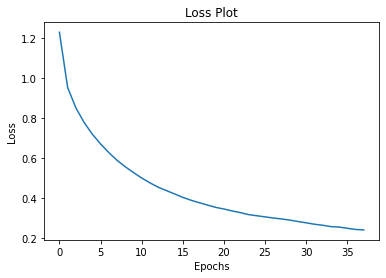

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()


In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()


Real Caption: a dog jumps for a yellow and black ball
Prediction Caption: white dog is jumping for a ball in its mouth while three white dog is jumping for a ball in its mouth while three white dog is jumping for a ball in its mouth while three white


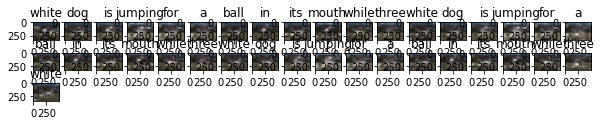

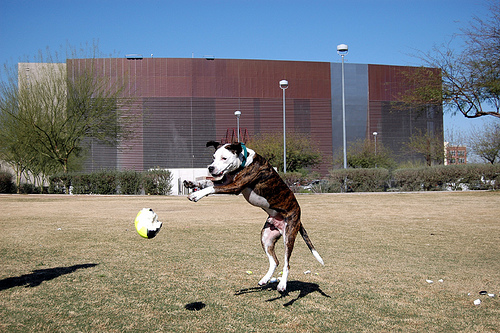

In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

for i in result:
    if i=="":
        result.remove(i)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
# opening the image
Image.open(img_name_val[rid])


In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
# opening the image
Image.open(img_name_val[rid])

In [ ]:

# n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'a', 'test','of', 'cricket', 'match']]
candidate = ['this', 'is', 'a', 'test','of', 'cricket', 'match']
print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))

In [ ]:

# longer candidate
from nltk.translate.bleu_score import sentence_bleu

rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)


first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "" in result
for i in result:
    if i=="":
        result.remove(i)


#remove  from result         
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final
score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open(img_name_val[rid])



In [ ]:

# longer candidate
from nltk.translate.bleu_score import sentence_bleu

rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)


first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "" in result
for i in result:
    if i=="":
        result.remove(i)


#remove  from result         
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final
score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open(img_name_val[rid])